In [1]:
# Imports
import sklearn
import numpy as np
import pandas as pd
from sklearn.model_selection import GridSearchCV, learning_curve, validation_curve, train_test_split, KFold, StratifiedKFold, cross_val_score
from sklearn.neural_network import MLPClassifier
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import AdaBoostClassifier
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix, precision_recall_fscore_support, make_scorer, accuracy_score, precision_score, recall_score, f1_score
from sklearn.exceptions import ConvergenceWarning
import warnings
import matplotlib.pyplot as plt
import seaborn as sns
import numbers
import time
import math
import csv
from multiprocessing import Pool

import mlrose_hiive as mlrose

from scoring import *

warnings.filterwarnings("ignore", category=ConvergenceWarning)
warnings.filterwarnings("ignore", category=UserWarning)
warnings.filterwarnings("ignore", category=RuntimeWarning)

plt.rcParams.update({'font.size': 16})

# Define an integer for random_state params
rng = 385678

n_jobs = 7

sample_sizes = np.linspace(0.1, 1.0, 10)

print(sorted(sklearn.metrics.SCORERS.keys()))

['accuracy', 'adjusted_mutual_info_score', 'adjusted_rand_score', 'average_precision', 'balanced_accuracy', 'completeness_score', 'explained_variance', 'f1', 'f1_macro', 'f1_micro', 'f1_samples', 'f1_weighted', 'fowlkes_mallows_score', 'homogeneity_score', 'jaccard', 'jaccard_macro', 'jaccard_micro', 'jaccard_samples', 'jaccard_weighted', 'matthews_corrcoef', 'max_error', 'mutual_info_score', 'neg_brier_score', 'neg_log_loss', 'neg_mean_absolute_error', 'neg_mean_absolute_percentage_error', 'neg_mean_gamma_deviance', 'neg_mean_poisson_deviance', 'neg_mean_squared_error', 'neg_mean_squared_log_error', 'neg_median_absolute_error', 'neg_root_mean_squared_error', 'normalized_mutual_info_score', 'precision', 'precision_macro', 'precision_micro', 'precision_samples', 'precision_weighted', 'r2', 'rand_score', 'recall', 'recall_macro', 'recall_micro', 'recall_samples', 'recall_weighted', 'roc_auc', 'roc_auc_ovo', 'roc_auc_ovo_weighted', 'roc_auc_ovr', 'roc_auc_ovr_weighted', 'top_k_accuracy', 

In [2]:
# Load data
# Source: https://www.kaggle.com/datasets/fedesoriano/heart-failure-prediction
df = pd.read_csv('heart.csv')

# Convert Categorical Labels
df['IsMale'] = np.where(df['Sex'] == 'M', 1, 0)
df['HasExerciseAngina'] =  np.where(df['ExerciseAngina'] == 'Y', 1, 0)

df['ChestPainType_TA'] = np.where(df['ChestPainType'] == 'TA', 1, 0)
df['ChestPainType_ATA'] = np.where(df['ChestPainType'] == 'ATA', 1, 0)
df['ChestPainType_NAP'] = np.where(df['ChestPainType'] == 'NAP', 1, 0)
#df['ChestPainType_ASY'] = np.where(df['ChestPainType'] == 'ASY', 1, 0)

#df['RestingECG_Normal'] = np.where(df['RestingECG'] == 'Normal', 1, 0)
df['RestingECG_ST'] = np.where(df['RestingECG'] == 'ST', 1, 0)
df['RestingECG_LVH'] = np.where(df['RestingECG'] == 'LVH', 1, 0)

#df['IsSTSlope_Flat'] =  np.where(df['ST_Slope'] == 'Flat', 1, 0)
df['IsSTSlope_Up'] = np.where(df['ST_Slope'] == 'Up', 1, 0)
df['IsSTSlope_Down'] = np.where(df['ST_Slope'] == 'Down', 1, 0)

df = df.drop(columns=['Sex', 'ExerciseAngina', 'ChestPainType', 'RestingECG', 'ST_Slope'])

print(df.head())
print(df.count())

   Age  RestingBP  Cholesterol  FastingBS  MaxHR  Oldpeak  HeartDisease  \
0   40        140          289          0    172      0.0             0   
1   49        160          180          0    156      1.0             1   
2   37        130          283          0     98      0.0             0   
3   48        138          214          0    108      1.5             1   
4   54        150          195          0    122      0.0             0   

   IsMale  HasExerciseAngina  ChestPainType_TA  ChestPainType_ATA  \
0       1                  0                 0                  1   
1       0                  0                 0                  0   
2       1                  0                 0                  1   
3       0                  1                 0                  0   
4       1                  0                 0                  0   

   ChestPainType_NAP  RestingECG_ST  RestingECG_LVH  IsSTSlope_Up  \
0                  0              0               0             1

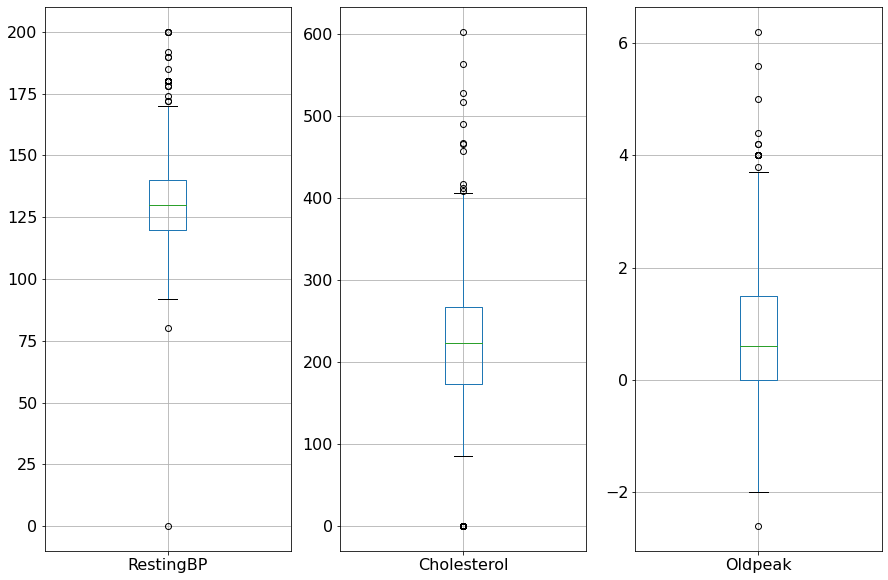

In [3]:
real_cols = ['RestingBP', 'Cholesterol', 'Oldpeak']

_, axes = plt.subplots(1, 3, figsize=(15,10))
for i, col in enumerate(real_cols):
    df.boxplot(column=[col], ax=axes[i])

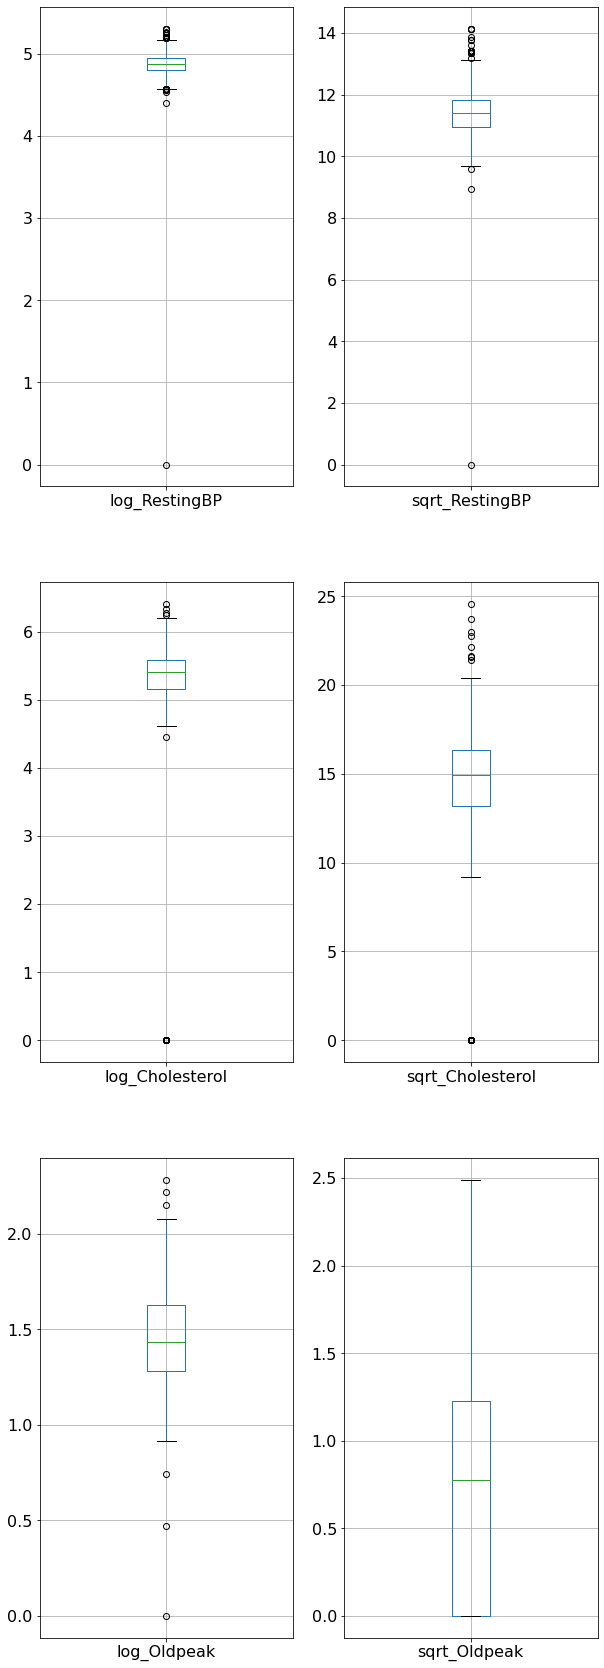

In [4]:
def safe_log(df):
    if df.min() <= 0.0:
        return np.log(df + np.abs(df.min()) + 1)
    else:
        return np.log(df)
    
transformation_fns = [('log', safe_log), ('sqrt', np.sqrt)]
  
_, axes = plt.subplots(3, 2, figsize=(10,30))
for i, name in enumerate(real_cols):
    for j, fn_info in enumerate(transformation_fns):
        fn_name, fn = fn_info
        col = f'{fn_name}_{name}'
        df[col] = fn(df[name])
        df.boxplot(column=[col], ax=axes[i, j])

In [5]:
# Drop columns
df = df.drop(columns=['RestingBP', 'sqrt_RestingBP', 'Cholesterol', 'sqrt_Cholesterol', 'Oldpeak', 'sqrt_Oldpeak'])
print(df.head())

   Age  FastingBS  MaxHR  HeartDisease  IsMale  HasExerciseAngina  \
0   40          0    172             0       1                  0   
1   49          0    156             1       0                  0   
2   37          0     98             0       1                  0   
3   48          0    108             1       0                  1   
4   54          0    122             0       1                  0   

   ChestPainType_TA  ChestPainType_ATA  ChestPainType_NAP  RestingECG_ST  \
0                 0                  1                  0              0   
1                 0                  0                  1              0   
2                 0                  1                  0              1   
3                 0                  0                  0              0   
4                 0                  0                  1              0   

   RestingECG_LVH  IsSTSlope_Up  IsSTSlope_Down  log_RestingBP  \
0               0             1               0       4.948760

In [6]:
for col in ['log_RestingBP', 'log_Cholesterol', 'log_Oldpeak']:
    q1 = df[col].quantile(0.25)
    q3 = df[col].quantile(0.75)
    iqr = q3 - q1
    margin = 1.5
    
    clean_df = df[ (df[col] >= q1 - margin * iqr) & (df[col] <= q3 + margin * iqr)]
    
    total_count = df[col].count()
    outlier_count = total_count - clean_df[col].count()
    
    print(f"{col}: outlier_count={outlier_count}, %={'%.4f' % (outlier_count / total_count)}")

    #df = clean_df

print(df.count())

log_RestingBP: outlier_count=34, %=0.0370
log_Cholesterol: outlier_count=177, %=0.1928
log_Oldpeak: outlier_count=6, %=0.0065
Age                  918
FastingBS            918
MaxHR                918
HeartDisease         918
IsMale               918
HasExerciseAngina    918
ChestPainType_TA     918
ChestPainType_ATA    918
ChestPainType_NAP    918
RestingECG_ST        918
RestingECG_LVH       918
IsSTSlope_Up         918
IsSTSlope_Down       918
log_RestingBP        918
log_Cholesterol      918
log_Oldpeak          918
dtype: int64


In [7]:
df_X = df.drop(columns=['HeartDisease'])
df_y = df['HeartDisease']

In [8]:
# Standardize data
scaler = StandardScaler()
df_X = pd.DataFrame(scaler.fit_transform(df_X, df_y), columns = df_X.columns)

                        Age  FastingBS     MaxHR    IsMale  HasExerciseAngina  \
Age                1.000000   0.198039 -0.382045  0.055750           0.215793   
FastingBS          0.198039   1.000000 -0.131438  0.120076           0.060451   
MaxHR             -0.382045  -0.131438  1.000000 -0.189186          -0.370425   
IsMale             0.055750   0.120076 -0.189186  1.000000           0.190664   
HasExerciseAngina  0.215793   0.060451 -0.370425  0.190664           1.000000   
ChestPainType_TA   0.032042   0.026885  0.100025 -0.004031          -0.128105   
ChestPainType_ATA -0.218165  -0.140514  0.253735 -0.161522          -0.300365   
ChestPainType_NAP -0.011335  -0.039249  0.134580 -0.066486          -0.166030   
RestingECG_ST      0.136798   0.127110 -0.157879  0.063715           0.107036   
RestingECG_LVH     0.145727  -0.011656  0.125793 -0.049518          -0.016382   
IsSTSlope_Up      -0.258067  -0.161730  0.383397 -0.150942          -0.455676   
IsSTSlope_Down     0.138397 

<AxesSubplot:>

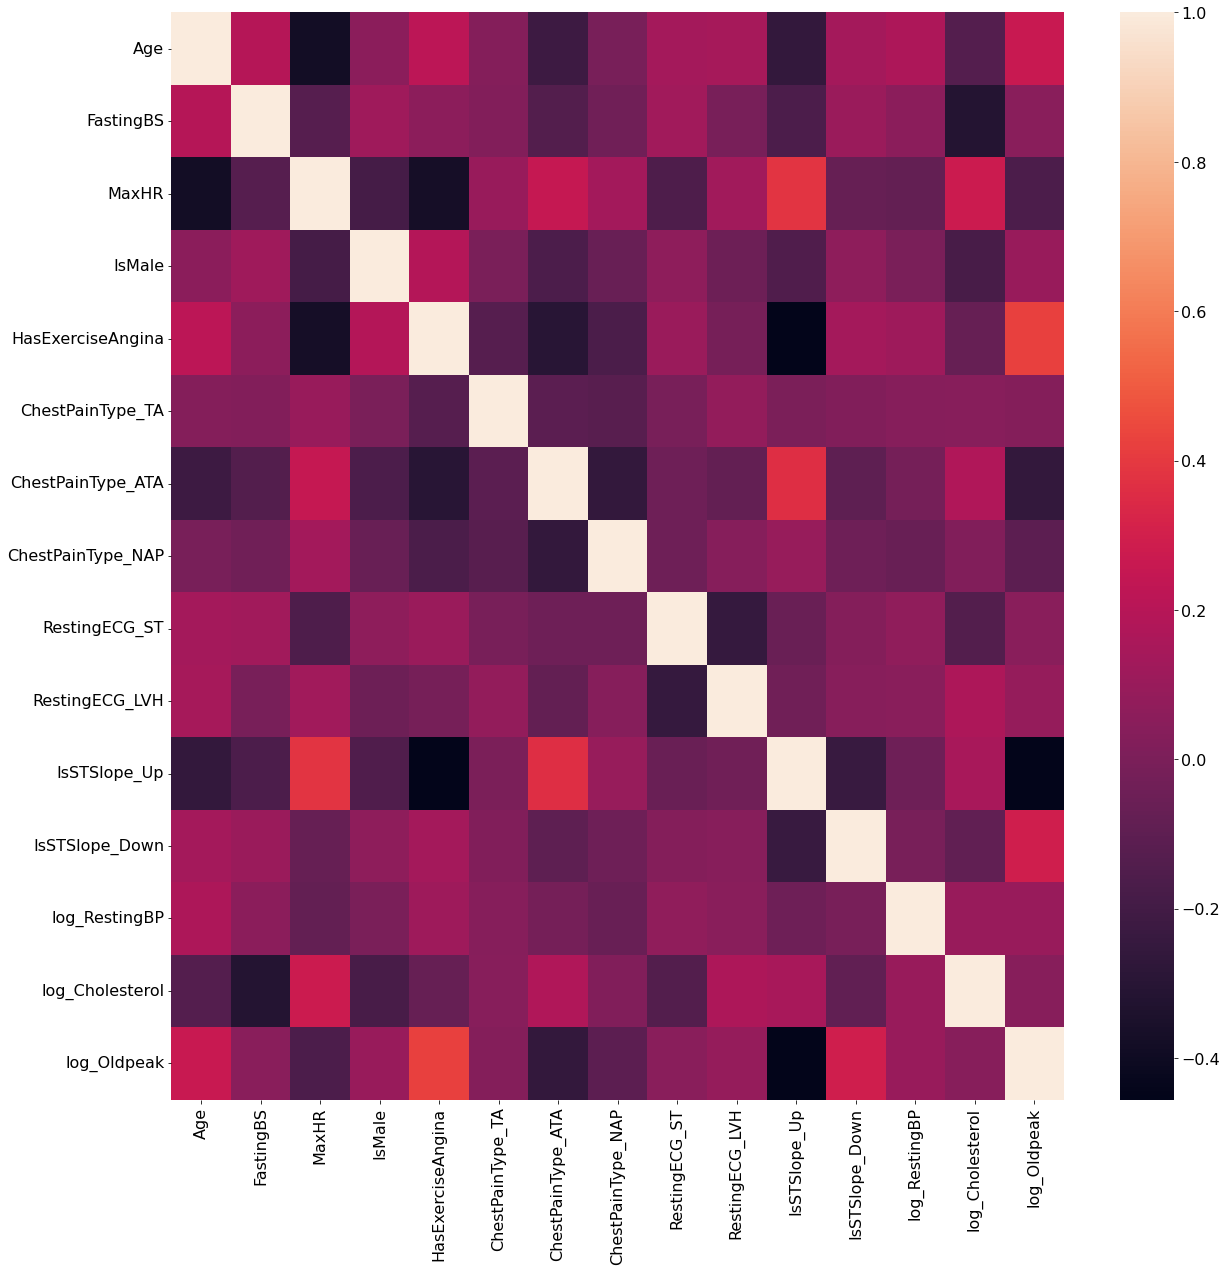

In [9]:
df_corr = df_X.corr()

print(df_corr)

# plot the heatmap
plt.figure(figsize=(20,20))
sns.heatmap(df_corr, 
        xticklabels=df_corr.columns,
        yticklabels=df_corr.columns)

In [10]:
cross_val = StratifiedKFold(shuffle=True, random_state=rng)

# "MLP": MLPClassifier(activation='relu', hidden_layer_sizes=(12), alpha=1.0, max_iter=1000)

default_kwargs = {
    'hidden_nodes': [12],
    'activation': 'relu',
    'max_iters': 100,
    'bias': True,
    'is_classifier': True,
    'learning_rate': 0.001,
    'early_stopping': False,
    'max_attempts': 100,
    'curve': True
}

algorithms = {
    'random_hill_climb': {
        'algorithm': 'random_hill_climb',
        'restarts': 99,
        'max_iters': 1000
    },
    'simulated_annealing': {
        'algorithm': 'simulated_annealing',
        'schedule': mlrose.ExpDecay(),
        'max_iters': 10000
    },
    'genetic_algorithm': {
        'algorithm': 'genetic_alg',
        'pop_size': 10000,
        'mutation_prob': 0.25,
        'max_iters': 100
    },
}

In [11]:
results = {}

def train_nn(algorithm, nn, train_X, train_y, test_X, test_y):
    st = time.time()
    nn.fit(train_X, train_y)
    et = time.time()
    print(f"{algorithm}: Completed in {et - st} seconds")
    y_pred = nn.predict(test_X)
    curve = nn.fitness_curve
    precision_val = precision_score(test_y, y_pred)
    npv_val = npv(test_y, y_pred)
    npv_precision_avg_val = npv_precision_avg(test_y, y_pred)
    runtime = et - st
    
    y_pred = nn.predict(train_X)
    train_precision_val = precision_score(train_y, y_pred)
    train_npv_val = npv(train_y, y_pred)
    train_npv_precision_avg_val = npv_precision_avg(train_y, y_pred)
    
    return runtime, nn, curve, precision_val, npv_val, npv_precision_avg_val, train_precision_val, train_npv_val, train_npv_precision_avg_val

threads_needed = len(algorithms) * cross_val.get_n_splits(df_X, df_y)
with Pool(min(16, threads_needed)) as pool:
    async_results = []
    for algorithm in algorithms:
        results[algorithm] = {
            'nn': [],
            'curve': [],
            'fevals': [],
            'precision': [],
            'npv': [],
            'npv_precision_avg': [],
            'runtime': [],
            'train_precision': [],
            'train_npv': [],
            'train_npv_precision_avg': []
        }
        for i, (train_index, test_index) in enumerate(cross_val.split(df_X, df_y)):
            kwargs = {**default_kwargs, **algorithms[algorithm], 'random_state': rng + i}
            train_X, train_y = df_X.iloc[train_index], df_y.iloc[train_index]
            test_X, test_y = df_X.iloc[test_index], df_y.iloc[test_index]
            nn = mlrose.NeuralNetwork(**kwargs)
            future = pool.apply_async(train_nn, (algorithm, nn, train_X, train_y, test_X, test_y))
            async_results.append((future, results[algorithm]))

    for async_result in async_results:
        future, store = async_result
        runtime, nn, curve, precision_val, npv_val, npv_precision_avg_val, train_precision, train_npv, train_npv_precision_avg  = future.get()
        store['nn'].append(nn)
        store['runtime'].append(runtime)
        store['curve'].append(curve[:, 0])
        store['fevals'].append(curve[:, 1])
        store['precision'].append(precision_val)
        store['npv'].append(npv_val)
        store['npv_precision_avg'].append(npv_precision_avg_val)
        store['train_precision'].append(train_precision)
        store['train_npv'].append(train_npv)
        store['train_npv_precision_avg'].append(train_npv_precision_avg)

        

simulated_annealing: Completed in 294.4979522228241 seconds
simulated_annealing: Completed in 295.7246425151825 seconds
simulated_annealing: Completed in 295.87755942344666 seconds
simulated_annealing: Completed in 298.18181324005127 seconds
simulated_annealing: Completed in 299.13630414009094 seconds
genetic_algorithm: Completed in 11278.498790025711 seconds
genetic_algorithm: Completed in 11291.001860380173 seconds
genetic_algorithm: Completed in 11301.139267921448 seconds
genetic_algorithm: Completed in 11304.89739227295 seconds
genetic_algorithm: Completed in 11322.292180538177 seconds
random_hill_climb: Completed in 12577.340899705887 seconds
random_hill_climb: Completed in 12587.048113584518 seconds
random_hill_climb: Completed in 12604.234303712845 seconds
random_hill_climb: Completed in 12614.443086385727 seconds
random_hill_climb: Completed in 12616.133056640625 seconds


In [12]:
stats = {}
for algorithm in results:
    stats[algorithm] = {}
    for stat in results[algorithm]:
        if stat != 'nn':
            stats[algorithm][stat] = np.vstack(results[algorithm][stat]).mean(axis=0)

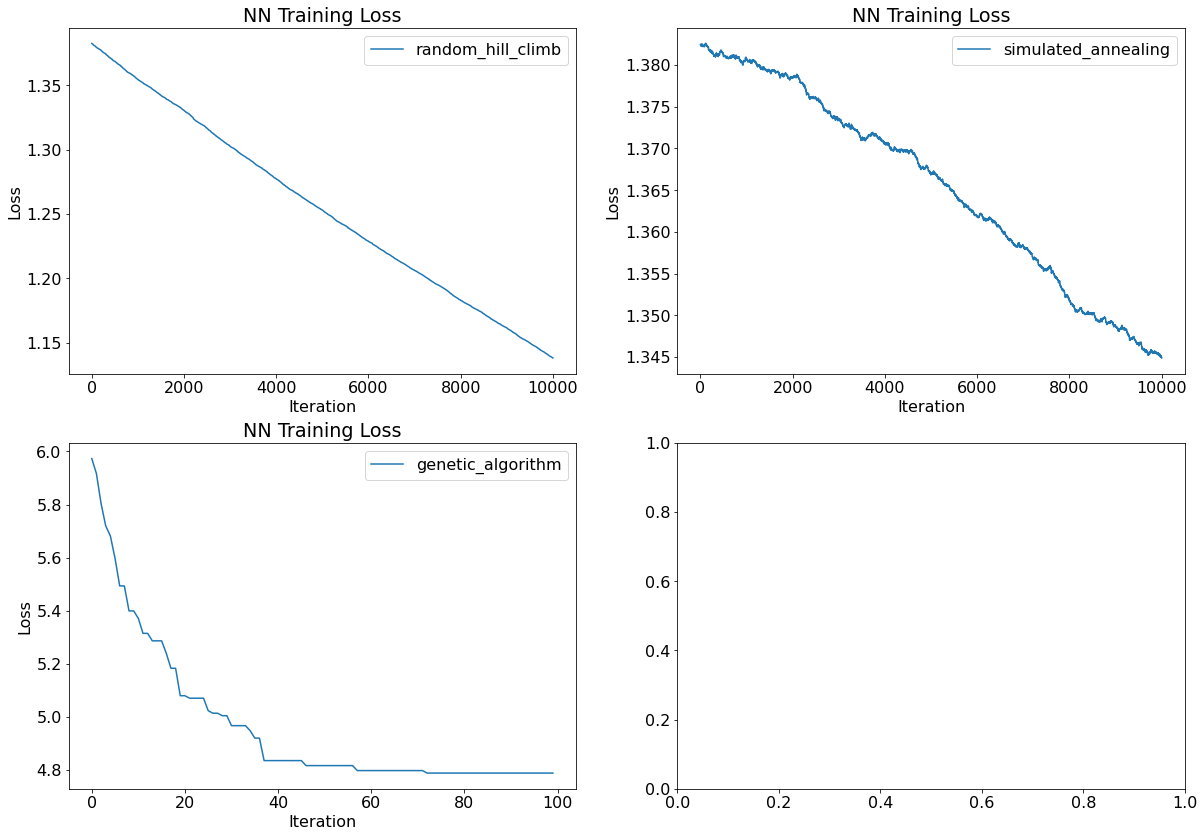

In [15]:
ncols = 2
nrows = int(math.ceil(len(algorithms) / ncols))

fig, axes = plt.subplots(nrows, ncols, figsize=(20, 7 * nrows))
for i, algorithm in enumerate(stats):
    ax = axes[i // ncols, i % ncols]
    
    ax.plot(list(range(algorithms[algorithm]['max_iters'])), stats[algorithm]['curve'], label=algorithm)
    ax.set_xlabel('Iteration')
    ax.set_ylabel('Loss')
    ax.legend()
    ax.set_title("NN Training Loss")
fig.show()

In [34]:
def render_table(row_labels, col_labels, cell_data, table_scale=(1, 4), **kwargs):
    fig, ax = plt.subplots(**kwargs)
    fig.patch.set_visible(False)
    ax.axis('off')
    ax.axis('tight')
    table = ax.table(
        cellText=cell_data, 
        rowLabels=col_labels, 
        colLabels=row_labels, 
        cellLoc='center',
        loc='upper left')
    table.set_fontsize(100)
    table.scale(*table_scale)
    #table.auto_set_font_size()
    fig.tight_layout()
    
    fig.show()
    return fig, ax

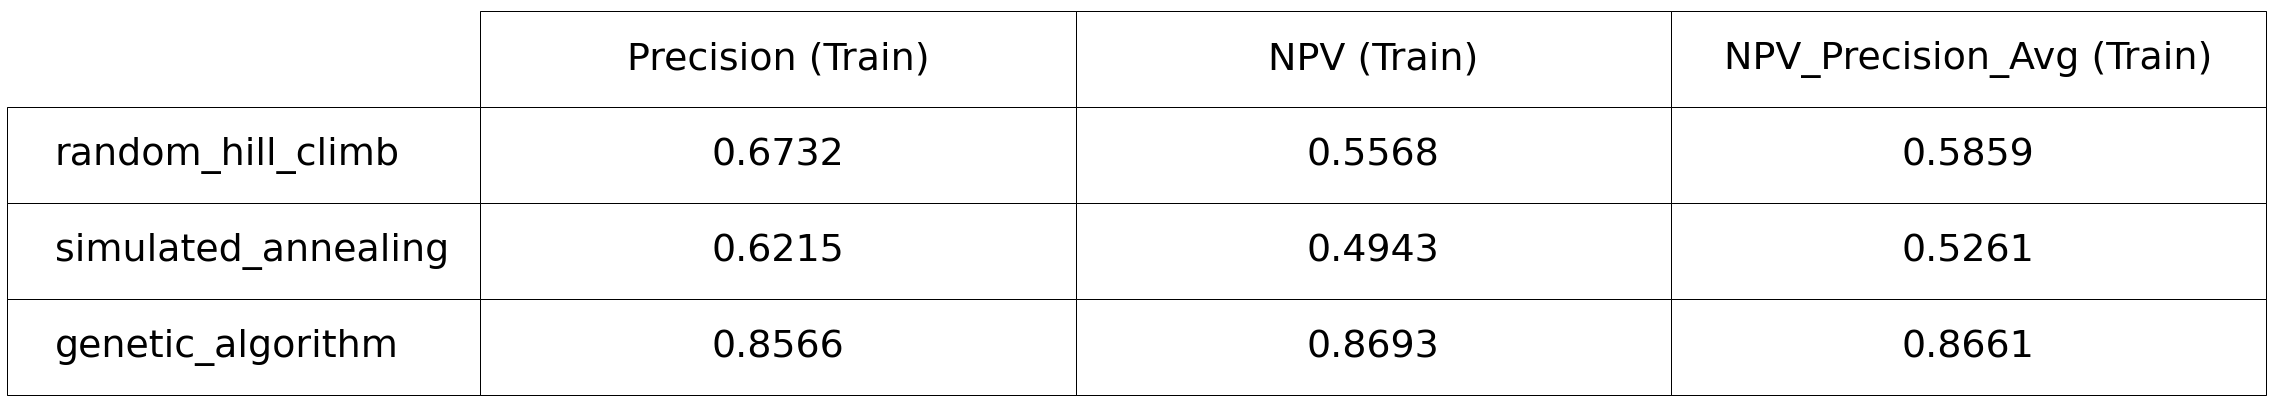

In [35]:
row_labels = ['Precision (Train)', 'NPV (Train)', 'NPV_Precision_Avg (Train)']
col_labels = list(algorithms)
cell_data = np.full((len(algorithms), len(row_labels)), '', dtype=object)
for i, algorithm in enumerate(algorithms):
    cell_data[i, 0] = '%.4f' % stats[algorithm]['train_precision']
    cell_data[i, 1] = '%.4f' % stats[algorithm]['train_npv']
    cell_data[i, 2] = '%.4f' % stats[algorithm]['train_npv_precision_avg']
fig, ax = render_table(row_labels, col_labels, cell_data, table_scale=(4, 8), figsize=(8,4))
fig.show()

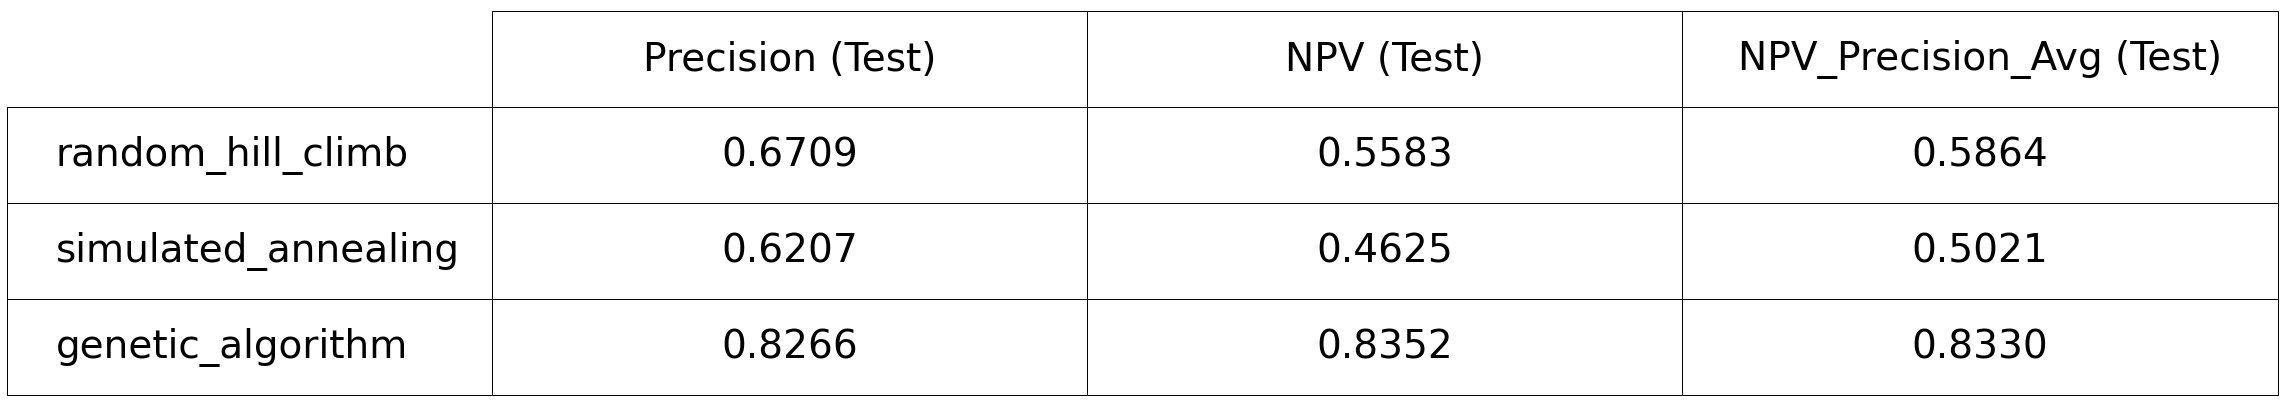

In [37]:
row_labels = ['Precision (Test)', 'NPV (Test)', 'NPV_Precision_Avg (Test)']
col_labels = list(algorithms)
cell_data = np.full((len(algorithms), len(row_labels)), '', dtype=object)
for i, algorithm in enumerate(algorithms):
    cell_data[i, 0] = '%.4f' % stats[algorithm]['precision']
    cell_data[i, 1] = '%.4f' % stats[algorithm]['npv']
    cell_data[i, 2] = '%.4f' % stats[algorithm]['npv_precision_avg']
fig, ax = render_table(row_labels, col_labels, cell_data, table_scale=(4, 8), figsize=(8,4))
fig.show()

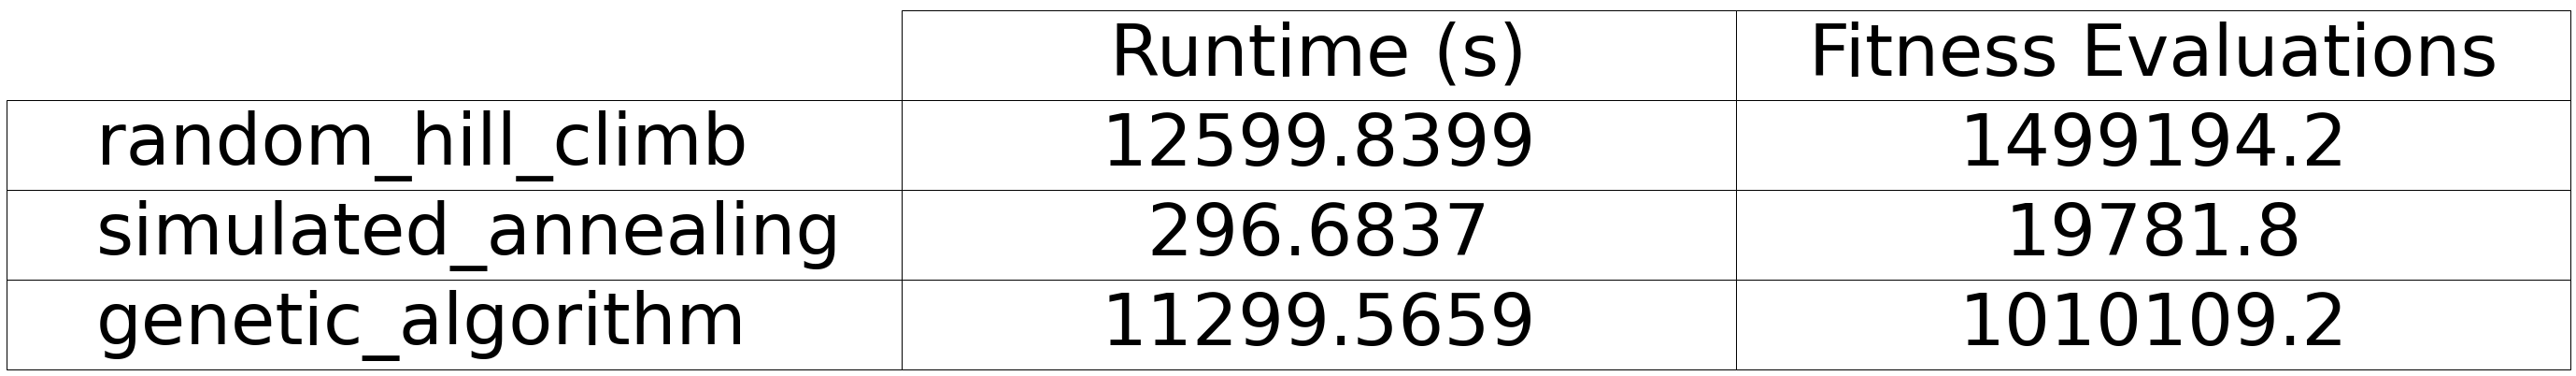

In [38]:
row_labels = ['Runtime (s)', 'Fitness Evaluations']
col_labels = list(algorithms)
cell_data = np.full((len(algorithms), len(row_labels)), '', dtype=object)
for i, algorithm in enumerate(algorithms):
    cell_data[i, 0] = '%.4f' % stats[algorithm]['runtime']
    cell_data[i, 1] = max(stats[algorithm]['fevals'])
fig, ax = render_table(row_labels, col_labels, cell_data, table_scale=(4, 8), figsize=(8,4))
fig.show()

In [41]:
from sklearn.metrics import accuracy_score
for algorithm in algorithms:
    nn = results[algorithm]['nn'][-1]
    train_acc = []
    test_acc = []
    for i, (train_index, test_index) in enumerate(cross_val.split(df_X, df_y)):
        train_X, train_y = df_X.iloc[train_index], df_y.iloc[train_index]
        test_X, test_y = df_X.iloc[test_index], df_y.iloc[test_index]
        y_pred = nn.predict(train_X)
        train_acc.append(accuracy_score(train_y, y_pred))
        y_pred = nn.predict(test_X)
        test_acc.append(accuracy_score(test_y, y_pred))
    train_acc = np.mean(train_acc)
    test_acc = np.mean(test_acc)
    print(f"{algorithm}: train_acc={train_acc}, test_acc={test_acc}")

random_hill_climb: train_acc=0.5664494244564311, test_acc=0.5664587788073175
simulated_annealing: train_acc=0.556644238076702, test_acc=0.5566345925397956
genetic_algorithm: train_acc=0.8507627574190438, test_acc=0.8507662152530292
